In [1]:
%%capture

import json
import speechbrain as sb
import os, sys
from speechbrain.utils.data_utils import get_all_files
import torch
from speechbrain.dataio.dataio import read_audio
import random
import torchaudio


In [2]:
torch.cuda.is_available()

True

In [11]:
# def get_all_json_data(json_info, file_name="train"):
#     data = {}
#     for sess_file in json_info:
#         if sess_file.endswith('.json'):
#             wav_path = sess_file.replace('_metadata.json', '_mixture.wav')
#             
#             with open(sess_file) as f:
#                 session_data = json.load(f)  
#                 
#             sess_id = os.path.basename(sess_file).split('_')[:-1]
#             sess_id = '_'.join(sess_id)
# 
#             item_data = {
#                 "wav_path": wav_path,
#                 "num_speakers": f"{session_data.get('num_speakers',sess_id.split('_')[-1])}",
#             }
#             # 
#             # for key, value in session_data.items():
#             #     if key != 'num_speakers':
#             #         item_data[key] = value
#             
#             # Assign the aggregated data to this session ID
#             data[sess_id] = item_data
#     
#     # Save combined metadata to JSON
#     metadata_path = os.path.join(f"{file_name}_data.json")
#     with open(metadata_path, "w") as jsonfile:
#         json.dump(data, jsonfile, indent=4)
#         
# # train_json_info = get_all_files("./maindata/train", match_and=['.json'])
# # dev_json_info = get_all_files("./maindata/dev", match_and=['.json'])
# # eval_json_info = get_all_files("./maindata/eval", match_and=['.json'])
# # 
# # get_all_json_data(train_json_info, file_name = "train")
# # get_all_json_data(dev_json_info, file_name = "dev")
# # get_all_json_data(eval_json_info, file_name = "eval")
# # print("Gathered all json data")

In [3]:
import json
from tqdm import tqdm
import torchaudio
from joblib import Parallel, delayed

def process_file(path):
    parts = path.split("/")[-1].split("\\")[-1].split("_")
    id = "_".join(parts[:-1])
    num_speakers = parts[3]
    info = torchaudio.info(path)
    length = info.num_frames / 16000

    return id, {
        "wav_path": path.replace("\\","/"),
        "num_speakers": num_speakers,
        "length": length
    }

def load_json(json_paths, save_file="train"):
    data = {}

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_file)(path) for path in json_paths
    )

    for id, path_data in results:
        data[id] = path_data

    with open(f"./maindata/{save_file}_data.json", 'w') as json_file:
        json.dump(data, json_file, indent=4)


train_files = get_all_files("./maindata/train", match_and=['_segment.wav'])
test_files = get_all_files("./maindata/dev", match_and=['_segment.wav'])
valid_files = get_all_files("./maindata/eval", match_and=['_segment.wav'])

load_json(train_files, save_file="train")
load_json(test_files, save_file="test")
load_json(valid_files, save_file="valid")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17880573575993783s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03566145896911621s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04600882530212402s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:    4.1s
[Parallel(n_job

In [13]:
%%file hparams_xvector_fbanks.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/XVector/UnAugmented/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
data_dir: ./maindata
train_annotation: !ref <data_dir>/train_data.json
valid_annotation: !ref <data_dir>/valid_data.json
test_annotation: !ref <data_dir>/test_data.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40
# deltas: True

# Training Parameters
sample_rate: 16000
number_of_epochs: 50
batch_size: 64
lr_start: 0.001
lr_final: 0.0001
weight_decay: 0.00002
# lr_patience: 1
n_classes: 5
emb_dim: 128 # dimensionality of the embeddings

dataloader_options:
    batch_size: !ref <batch_size>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>
    # deltas: !ref <deltas>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

# Embedding model: from variable size digits gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
# 
# opt_class: !name:torch.optim.Adadelta
#     lr: !ref <lr>
#     rho: 0.95
#     eps: 1.e-8

# opt_class: !name:torch.optim.AdamW
#     lr: 0.001
#     weight_decay: 0.02

opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>
    weight_decay: !ref <weight_decay>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.

# lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
#     mode: triangular2
#     gamma: 0.9998
#     base_lr: 0.001 #best for adam
#     max_lr: 0.004 #hope that it escapes local minima
#     step_size: 9935 #317920/64 = 4967.5 *2-8 == 9935-39740



lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
   initial_value: !ref <lr_start>
   final_value: !ref <lr_final>
   epoch_count: !ref <number_of_epochs>

# 
# lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
#     initial_value: !ref <lr>
#     improvement_threshold: 0.0025
#     annealing_factor: 0.8
#     patient: 0

# lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
#     lr_min: !ref <lr_final>
#     dont_halve_until_epoch: !ref <lr_dont_halve_until_epoch>
#     patience: !ref <lr_patience>

# lr_annealing_model_3: !new:speechbrain.nnet.schedulers.CyclicCosineScheduler
#   lr_initial: !ref <peak_lr>
#   n_warmup_steps: !ref <warmup_steps>
#   total_steps: !ref <total_step>



# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Overwriting hparams_xvector_fbanks.yaml


In [14]:
%%file train_xvector_fbanks.py
# Your code here

#!/usr/bin/env python3
"Recipe for training a spk classification system."
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


# Brain class for speech enhancement training
class DigitBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)
        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch['sig']
        num_speakers_encoded = batch["num_speakers_encoded"].data

        loss = sb.nnet.losses.nll_loss(predictions, num_speakers_encoded, lens)
        self.loss_metric.append(
            batch.id, predictions, num_speakers_encoded, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, num_speakers_encoded, lens)
        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()
    print(label_encoder)

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav_path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav_path):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav_path)

        # Resampling
        sig = torchaudio.functional.resample(sig, fs, 16000).squeeze(0)
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("num_speakers")
    @sb.utils.data_pipeline.provides("num_speakers", "num_speakers_encoded")
    def label_pipeline(num_speakers):
        """Defines the pipeline to process the spk labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield num_speakers
        num_speakers_encoded = label_encoder.encode_label_torch(num_speakers)
        yield num_speakers_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "num_speakers_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="num_speakers",
    )

    return datasets


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    # Initialize the Brain object to prepare for mask training.
    digit_brain = DigitBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    digit_brain.fit(
        epoch_counter=digit_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = digit_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_xvector_fbanks.py


In [9]:
# !rm -rf results/train

# Run Training
torch.cuda.set_device('cuda:0')
# !python train_xvector_fbanks.py hparams_xvector_fbanks.yaml

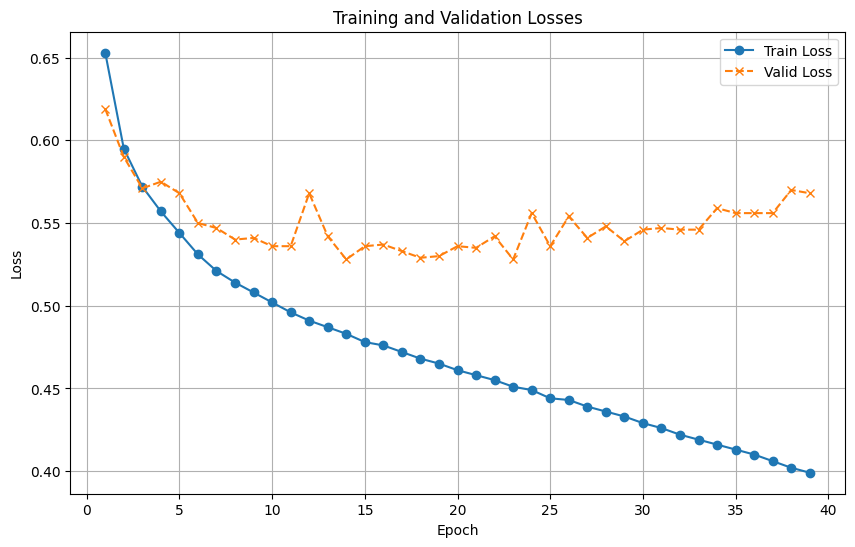

In [16]:
import matplotlib.pyplot as plt
import re

log_file_path = './results/Xvector/UnAugmented/1986/train_log.txt'
# log_file_path = './results_backup_reduceonplateau/TIMIT_tiny/Xvector/FBanks/1986/train_log.txt'

epochs = []
train_losses = []
valid_losses = []
valid_errors = []
learning_rates = []

pattern = re.compile(r'Epoch: (\d+), lr: (\d\.\d+e-\d{2}) - train loss: (\d\.\d+e-\d{2}) - valid loss: (\d\.\d+e-\d{2}), valid error: (\d\.\d+e-\d{2})')

with open(log_file_path, 'r') as file:
    for line in file:
        match = pattern.match(line)
        if match:
            epoch, lr, train_loss, valid_loss, valid_error = match.groups()
            epochs.append(int(epoch))
            learning_rates.append(float(lr))
            train_losses.append(float(train_loss))
            valid_losses.append(float(valid_loss))
            valid_errors.append(float(valid_error))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()